In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import pywt
from scipy.stats import entropy
from collections import deque
import matplotlib.patches as patches

### Load Dictionary .npy

In [20]:
dictionary = np.load('dictionary.npy', allow_pickle=True).item()
print(type(dictionary))
volunteers = sorted(dictionary.keys())
print('Volunteers:',volunteers)

<class 'dict'>
Volunteers: ['S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30', 'S31']


### Signals access example

In [21]:
print(dictionary['S01'].keys())
print(dictionary['S01']['Lower'].keys())
print(dictionary['S01']['Lower']['Task1'].keys())
print(dictionary['S01']['Lower']['Task1']['X'].keys())

dict_keys(['Lower', 'Upper'])
dict_keys(['Task1', 'Task2', 'Task3'])
dict_keys(['X', 'Y'])
dict_keys(['Left', 'Rest', 'Right'])


In [22]:
df_info = pd.read_excel('C:/Users/Usuario/Documents/GitHub/Data_base_processing/Database_Info.xlsx')
upper_dominant = (df_info["Upper Dominant Laterality"]).tolist()
lower_dominant = (df_info["Lower Dominant Laterality"]).tolist()
print('Upper dominant=',upper_dominant)
print('Lower dominant=',lower_dominant)

Upper dominant= ['Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left']
Lower dominant= ['Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left', 'Right', 'Right', 'Right', 'Right', 'Right', 'Right', 'Left']


# Wavelet Packet LDB - Feet

In [23]:
feet_channels = ['CZ', 'C4', 'C3', 'FZ', 'PZ']

trials, channels, samples = dictionary['S01']['Lower']['Task1']['X']['Rest'].shape
print(f"Trials={trials}|Channels={channels}|Samples={samples}")

volunteer = 3

if volunteer < 10:
    ini = 'S0'
else:
    ini = 'S'

X = dictionary[ini+str(volunteer)]['Lower']['Task1']['X']
Y = dictionary[ini+str(volunteer)]['Lower']['Task1']['Y']

Trials=80|Channels=5|Samples=1000


### Signal channel mean

In [24]:
def graph_mean_feet(trials, feet_channels,title):
    signals_class = { 'CZ': [], 'C4': [], 'C3': [], 'FZ': [], 'PZ': [] }
    
    # Construir signals_class
    for trial in range(len(trials)):
        signals_class['CZ'].append(trials[trial][0])
        signals_class['C4'].append(trials[trial][1])
        signals_class['C3'].append(trials[trial][2])
        signals_class['FZ'].append(trials[trial][3])
        signals_class['PZ'].append(trials[trial][4])

    # Crear la figura y los ejes
    fig, axes = plt.subplots(1, 5, figsize=(16, 4))

    # Graficar señales
    for idx, channel in enumerate(signals_class.keys()):
        mean = np.mean(signals_class[channel], axis=0)
        std = np.std(signals_class[channel], axis=0)
        
        axes[idx].plot(mean, label='Mean')
        axes[idx].fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5)
        axes[idx].set_title(feet_channels[idx])
        axes[idx].legend()
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()



(40, 5, 1000)


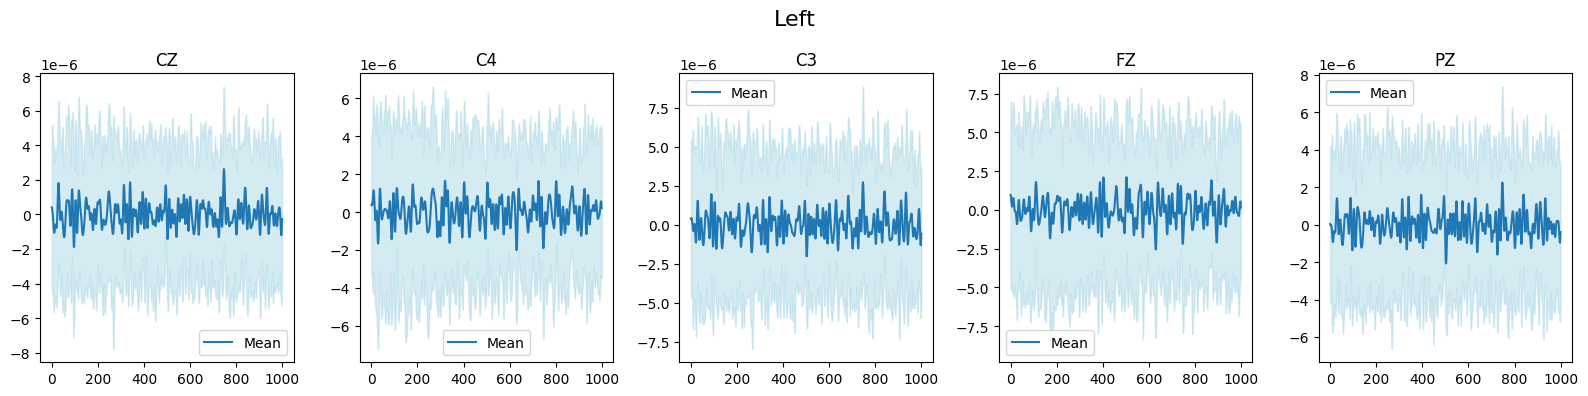

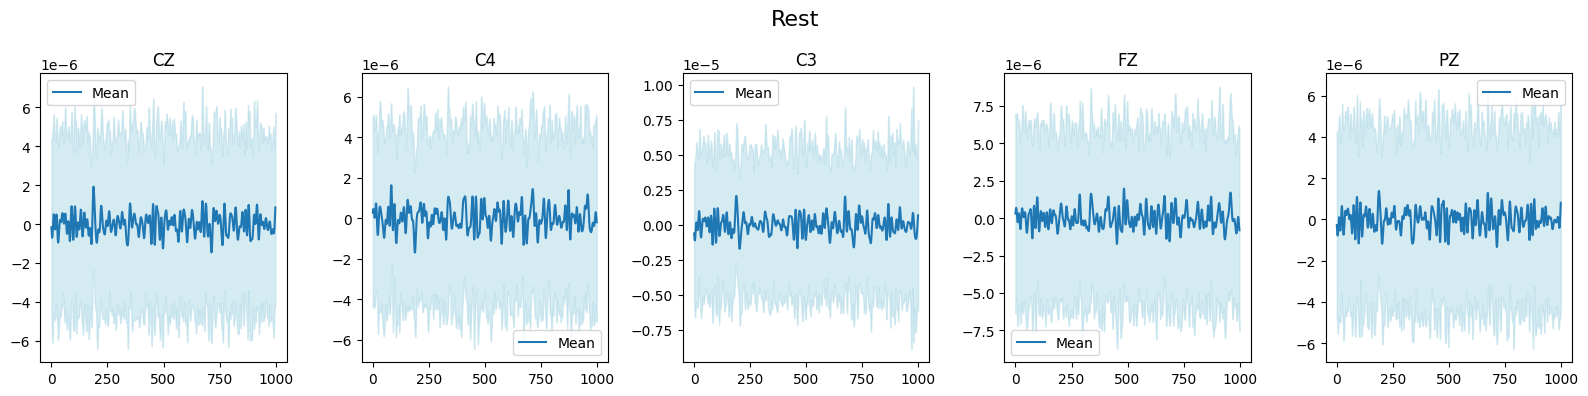

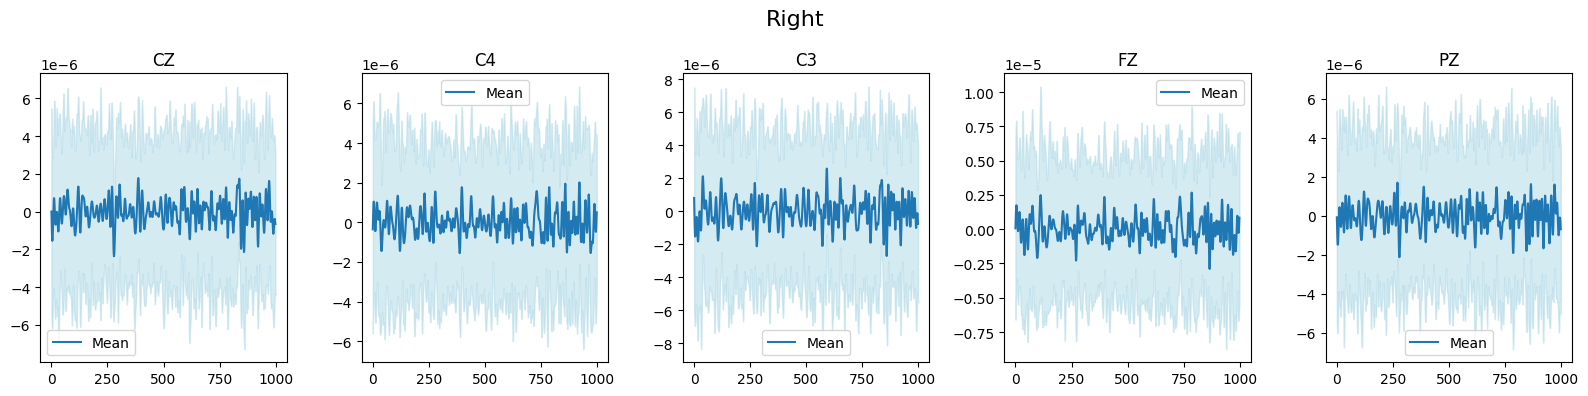

In [25]:
print((X['Left'].shape))
graph_mean_feet(X['Left'],feet_channels,'Left')
graph_mean_feet(X['Rest'],feet_channels,'Rest')
graph_mean_feet(X['Right'],feet_channels,'Right')
   

### Laplace filter

In [26]:
def laplacian_filter(senal):
  samples, channels, trials = senal.shape
  laplacian = np.empty((samples, trials), np.float64) 

  for i in range(trials):
      for k in range(samples):
          sample_sum = 0
          for j in range(channels - 1):
              sample_sum += senal[k, j, i] 
          laplacian[k, i] = senal[k, channels - 1, i] - (sample_sum / (channels - 1))  
  return laplacian

In [27]:
laplace_left = laplacian_filter(X['Left'])
trials, samples = laplace_left.shape
print(f"Left Trials={trials}|Samples={samples}")
laplace_right = laplacian_filter(X['Right'])
trials, samples = laplace_right.shape
print(f"Right Trials={trials}|Samples={samples}")
laplace_rest = laplacian_filter(X['Rest'])
trials, samples = laplace_rest.shape
print(f"Rest Trials={trials}|Samples={samples}")

Left Trials=40|Samples=1000
Right Trials=40|Samples=1000
Rest Trials=80|Samples=1000


In [28]:
# Graficar señales
def graph_signals(signals, title, x_axis=None):
    fig = plt.figure(figsize=(16, 4))
    mean = np.mean(signals, axis=0)
    std = np.std(signals, axis=0)

    if x_axis is None:
        x_axis = range(len(mean))  # Por defecto, usa 0 al número de muestras
    
    
    plt.plot(mean, label='Mean')
    plt.fill_between(range(len(mean)), mean - std, mean + std, color='lightblue', alpha=0.5)
    plt.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

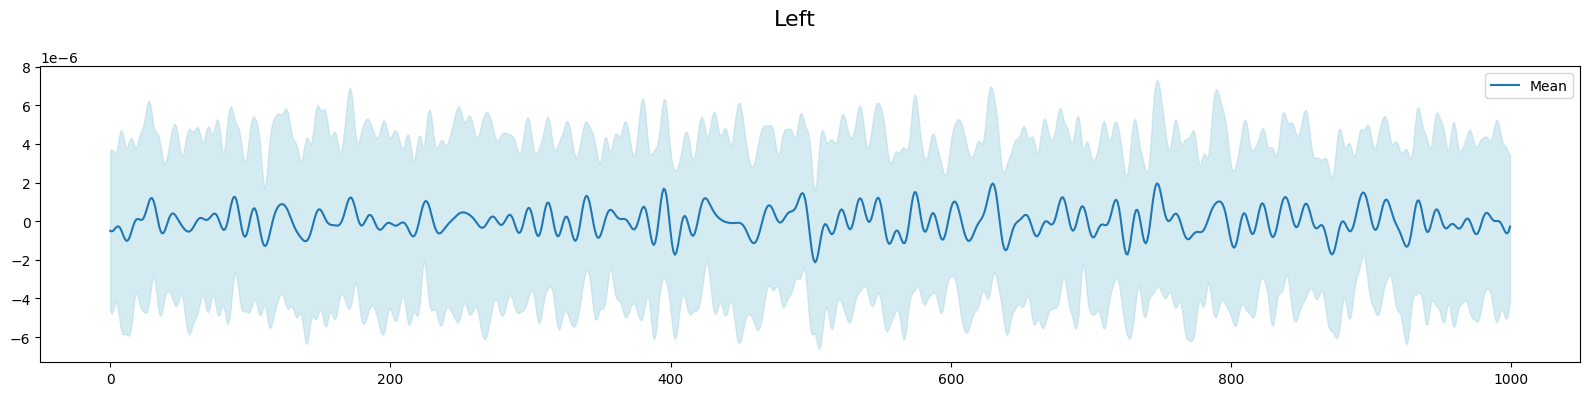

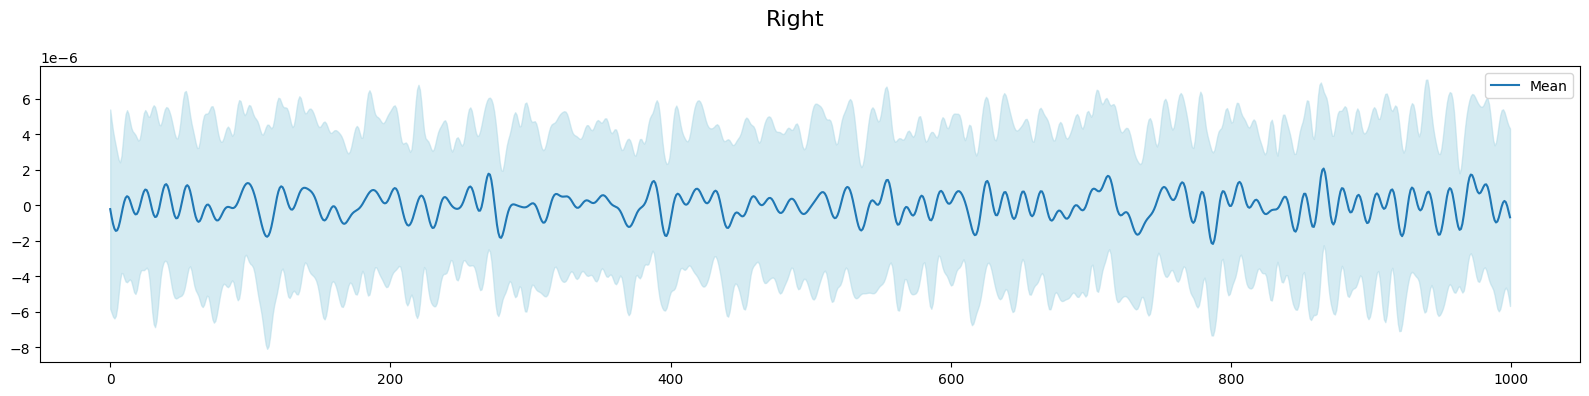

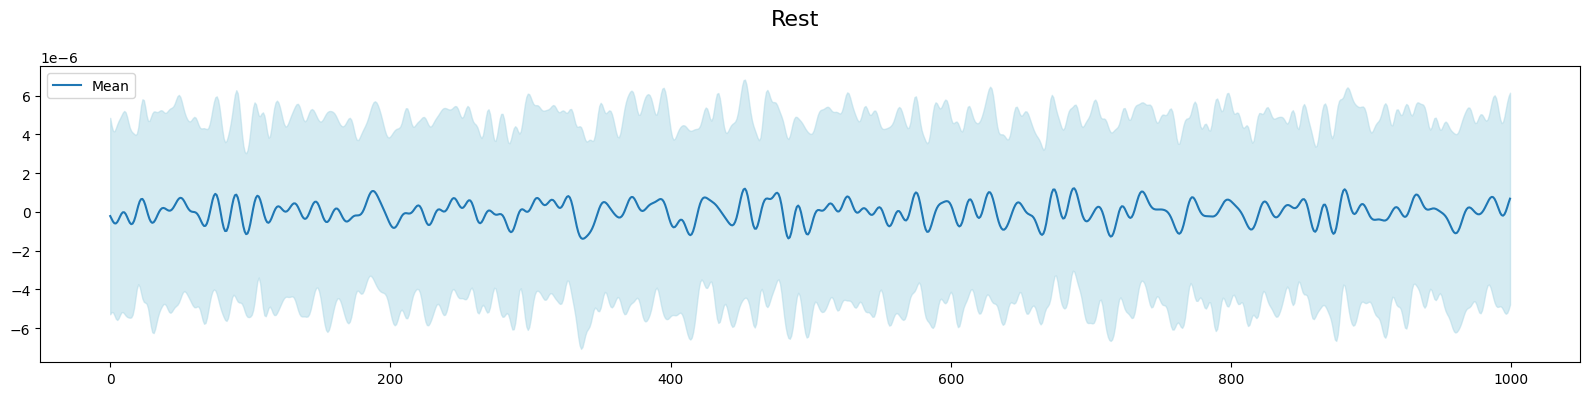

In [29]:
graph_signals(laplace_left,'Left')
graph_signals(laplace_right,'Right')
graph_signals(laplace_rest,'Rest')

In [30]:
if lower_dominant[volunteer-1] == 'Right':
    index = np.random.choice(laplace_rest.shape[0], 40, replace=False) 
    selection = laplace_rest[index]
    X = np.concatenate((laplace_right, selection), axis=0)
else:
    index = np.random.choice(laplace_rest.shape[0], 40, replace=False) 
    selection = laplace_rest[index]
    X = np.concatenate((laplace_left, selection), axis=0)

y = np.concatenate((np.ones(40),np.zeros(40)), axis=0)

print('Tamaño X:', X.shape, 'Tamaño y:', y.shape)

Tamaño X: (80, 1000) Tamaño y: (80,)


### Wavelet Packet LDB

Wavelet packet + LDB
1. Descomposición WPD → Se crea un árbol binario con coeficientes wavelet.
2. Cálculo de energía → Se mide la energía en cada nodo.
3. Medida de discriminación → Se evalúa qué nodos separan mejor las clases.
4. Selección de nodos → Se eligen los más discriminantes.
5. Extracción de coeficientes → Se obtienen los coeficientes relevantes.

In [31]:
from collections import defaultdict

class WP_LDB():
    def __init__(self, signals_array, classes_array, wavelet='bior2.8', levels_decomposition=5):
        self.signals_array = signals_array
        self.classes_array = classes_array
        self.wavelet = wavelet
        self.levels_decomposition = levels_decomposition
    
    def WP_energy(self):

        def wp_decomposition(signal):
            wpt = pywt.WaveletPacket(data=signal, wavelet=self.wavelet, mode='periodization',maxlevel=self.levels_decomposition)
            return wpt
        
        def wp_energy_decomposition(wpt):
            energy_per_node = {}
            node_names = [] 
            total_coefficients_energy = 0.0
            
            for level in range(self.levels_decomposition + 1):
                nodes_at_level = wpt.get_level(level)
                for node in nodes_at_level:
                    energy = np.sum(node.data ** 2)
                    total_coefficients_energy += energy
            
            for level in range(self.levels_decomposition + 1):
                nodes_at_level = wpt.get_level(level)
                for node in nodes_at_level:
                    energy = np.sum(node.data ** 2)
                    energy_per_node[node.path] = energy / total_coefficients_energy
                    node_names.append(node.path)           
            return energy_per_node, node_names

        def Energy_nodes(data, nodes_names):
            energy_per_level = defaultdict(list)  
            for trial in data: 
                for node, value in trial.items():  
                    energy_per_level[node].append(value) 
            return dict(energy_per_level) 

        WP_class_1 = []
        WP_class_0 = []
        all_node_names = []
        for signal, cls in zip(self.signals_array,self.classes_array):
            wp = wp_decomposition(signal)
            energy_per_node, node_names = wp_energy_decomposition(wp)
            for name in node_names:
                if name not in all_node_names:
                    all_node_names.append(name)
            if cls == 1:           
                WP_class_1.append(energy_per_node)
            else:
                WP_class_0.append(energy_per_node)

        for trial in WP_class_0 + WP_class_1:
            for node in all_node_names:
                if node not in trial:
                    trial[node] = 0.0
            
        Enode_class0 = {node: [trial[node] for trial in WP_class_0] for node in all_node_names}
        Enode_class1 = {node: [trial[node] for trial in WP_class_1] for node in all_node_names}

        return Enode_class0, Enode_class1, all_node_names
    
    def WP_discrimination(self, Enode_class0, Enode_class1, nodes_names, dis_method = 'KL'):

        def Fisher_Criteria(Class_0, Class_1):
            mu_c0 = np.mean(Class_0)
            mu_c1 = np.mean(Class_1)
            sigma_c0 = np.var(Class_0, ddof=1)  
            sigma_c1 = np.var(Class_1, ddof=1)
    
            denominator = sigma_c0 + sigma_c1
            if denominator == 0:
                return 0.0  
            FD = (mu_c0 - mu_c1)**2 / denominator
            return FD
            # Cuanto mayor sea FD mas separadas están las clases
        
        def kullback_Leibler(Class_0, Class_1, bins=20, epsilon=1e-10):
            min_val = min(np.min(Class_0), np.min(Class_1))
            max_val = max(np.max(Class_0), np.max(Class_1))
            
            hist_c0, _ = np.histogram(Class_0, bins=bins, range=(min_val, max_val), density=True)
            hist_c1, _ = np.histogram(Class_1, bins=bins, range=(min_val, max_val), density=True)
            
            hist_c0 += epsilon
            hist_c1 += epsilon
            
            p = hist_c0 / np.sum(hist_c0)
            q = hist_c1 / np.sum(hist_c1)
            
            kl_divergence = np.sum(p * np.log(p / q))
            return kl_divergence
        
        def diferential_energy(Class_0, Class_1):
            energy_A = np.mean(np.square(Class_0))
            energy_B = np.mean(np.square(Class_1))
            return np.abs(energy_A - energy_B)
        
        def compute_renyi_entropy(coeffs, alpha=2, bins=20, epsilon=1e-10):
            hist, _ = np.histogram(coeffs, bins=bins, density=True)
            hist += epsilon
            hist /= np.sum(hist) 
            if alpha == 1:
                return -np.sum(hist * np.log(hist))  
            else:
                return (1 / (1 - alpha)) * np.log(np.sum(hist ** alpha))
            
        def renyi_diff(Class_0, Class_1, alpha=2, bins=20):
            H0 = compute_renyi_entropy(Class_0, alpha, bins)
            H1 = compute_renyi_entropy(Class_1, alpha, bins)
            return np.abs(H0 - H1)

        
        Discriminant = []
        for node in nodes_names:
            if dis_method == 'KL':
                Discriminant.append(kullback_Leibler(Enode_class0[node],Enode_class1[node]))
            elif dis_method == 'FC':
                Discriminant.append(Fisher_Criteria(Enode_class0[node],Enode_class1[node]))
            elif dis_method == 'DE':
                Discriminant.append(diferential_energy(Enode_class0[node],Enode_class1[node]))
            elif dis_method == 'RY':
                Discriminant.append(renyi_diff(Enode_class0[node],Enode_class1[node]))
        nodes_names[0] = 'root'
        return nodes_names, Discriminant

from collections import deque

class Node:
    def __init__(self, score, name):
        self.score = score  
        self.name = name
        self.base = None    
        self.a = None    
        self.d = None

    @staticmethod
    def build_binary_tree(scores, names):
        if not scores or scores[0] is None:
            return None

        root = Node(scores[0], names[0])
        queue = deque([root])
        index = 1

        while queue and index < len(scores):
            current_node = queue.popleft()

            # Left child
            if index < len(scores) and scores[index] is not None:
                current_node.a = Node(scores[index], names[index])
                queue.append(current_node.a)
            index += 1

            # Right child
            if index < len(scores) and scores[index] is not None:
                current_node.d = Node(scores[index], names[index])
                queue.append(current_node.d)
            index += 1

        return root
    
    def print_tree(root):
        if not root:
            return

        queue = deque([(root, 0)])  
        niveles = {} 

        while queue:
            node, level = queue.popleft()
            
            if level not in niveles:
                niveles[level] = []
            niveles[level].append(f"{node.name}({node.score})")
            
            if node.a:
                queue.append((node.a, level + 1))
            if node.d:
                queue.append((node.d, level + 1))

        for level in sorted(niveles.keys()):
            print("    " * (len(niveles) - level), "  ".join(niveles[level]))

    
    def prune(self, modified_nodes = None):
        if self is None:
            return None
        
        if modified_nodes is None:
            modified_nodes = []  

        if self.a:
            self.a = self.a.prune()
        if self.d:
            self.d = self.d.prune()

        suma_hijos = 0
        if self.a:
            suma_hijos += self.a.score
        if self.d:
            suma_hijos += self.d.score

        if suma_hijos > self.score:
            if self.a and self.d:
                self.score = self.a.score + self.d.score
                modified_nodes.append(self.a.name)
                modified_nodes.append(self.d.name) 
                self.name = f'{self.a.name}-{self.d.name}' 
                self.a = None
                self.d = None
        else:
            if self.a:
                self.a = None
            if self.d:
                self.d = None
        
        self.base = self.name.split('-')
        return self
    
    def discriminant_base(self, discriminant, nodes):
        index = []
        scores = []
        for node in self.base:
            index.append(nodes.index(node))
        for i in index:
            scores.append(discriminant[i])
        combination = list(zip(scores, self.base))
        combination.sort(key=lambda x: x[0], reverse=True)
        scores, nodes = zip(*combination)
        #print(scores)
        #print(nodes)
        return nodes, scores  
    
    

In [32]:
class LDB_Decomposition():
    def __init__(self, X, y, mother = 'bior2.8' ,discriminant_method = 'KL', level = 5):
        self.X = X
        self.y = y
        self.mother = mother
        self.discriminant_method = discriminant_method
        self.level = level
        self.basis = None
        self.basis_score = None
        self.nodes_names = None

    def LDB_WP(self): 
        wp = WP_LDB(self.X, self.y, self.mother)
        Ec0, Ec1, nodes = wp.WP_energy()
        self.nodes_names = nodes
        nodes, discriminant = wp.WP_discrimination(Ec0, Ec1, nodes, dis_method = self.discriminant_method)
        tree = Node.build_binary_tree(discriminant, nodes)
        Node.print_tree(tree)
        tree.prune()
        self.basis, self.basis_score = tree.discriminant_base(discriminant, nodes)

    def LDB_fit(self, X):
        
        def wp_decomposition(self, signal):
            wpt = pywt.WaveletPacket(data=signal, wavelet=self.mother, mode='periodization',maxlevel=self.level)
            return wpt

        features = []
        for signal in X:
            coeficients = np.array([])
            s = wp_decomposition(self,signal)
            for node in self.basis:
                coeficients = np.concatenate((coeficients,s[node].data))
            #print((coeficients))
            features.append(coeficients)
        return features
    
    def nodes_maps(self, cmap_name='winter'):
        # Precomputación de valores
        max_score = np.max(self.basis_score) or 1e-10  # Evitar división por cero
        scores_norm = self.basis_score / max_score
        scores_norm = np.linspace(1, 0, len(self.basis_score))
        cmap = plt.get_cmap(cmap_name)
        
        # Mapeo de colores optimizado
        color_dict = {node: cmap(score) 
                    for node, score in zip(self.basis, scores_norm)}
        
        # Configuración inicial del plot
        fig, ax = plt.subplots(figsize=(4, 10))
        ax.set_aspect('equal')
        ax.axis('off')
        
        # Parámetros geométricos
        base_width = 1.0
        level_heights = np.linspace(0, -1, self.level + 1)  # Espaciado uniforme entre niveles
        height = -1 / (self.level + 1)  # Altura proporcional al número de niveles
        
        for level in range(self.level + 1):
            n_nodes = 2 ** level
            node_width = base_width / n_nodes
            
            for node_idx in range(n_nodes):
                x_pos = node_idx * node_width
                y_pos = level_heights[level]  # Sin escalamiento extra

                node_name = self._get_node_name(level, node_idx)
                edge_color = 'black'
                face_color = color_dict.get(node_name, 'white')

                rect = patches.Rectangle(
                    (x_pos, y_pos),
                    node_width,
                    height,  # Usa la nueva altura proporcional
                    edgecolor=edge_color,
                    facecolor=face_color,
                    linewidth=0.5
                )
                ax.add_patch(rect)

         # Añadir título
        ax.set_title("Discriminant nodes map", fontsize=16)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
        sm.set_array([]) 
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.04)
        cbar.set_label('Discriminant score', fontsize=12)
    
        plt.autoscale()
        plt.tight_layout()
        return fig, ax

    def _get_node_name(self, level, idx):
        """Genera nombres de nodos basado en nivel e índice"""
        if level == 0:
            return 'root'
        return ''.join(['d' if (idx >> i) & 1 else 'a' 
                    for i in reversed(range(level))])
                




                         root(4.409040931723819e-05)
                     a(6.788927081744986e-05)  d(1.133962360040556e-08)
                 aa(0.00017201463079472012)  ad(6.224205530104249e-07)  da(7.679405117241204e-09)  dd(1.0667876874587405e-09)
             aaa(0.00011206277437047357)  aad(7.5692588307017935e-06)  ada(1.0576500831316293e-08)  add(1.6907338469634326e-07)  daa(2.628607917421217e-09)  dad(1.0276991141629577e-09)  dda(2.1110899766053672e-10)  ddd(2.7167504627885394e-10)
         aaaa(0.00016029918413631213)  aaad(2.9944253119546654e-05)  aada(1.6211484514937771e-07)  aadd(1.0969672243544139e-05)  adaa(1.377526486234784e-08)  adad(1.803717840290303e-08)  adda(9.926035265513334e-08)  addd(4.03395072062204e-08)  daaa(3.414665823859565e-10)  daad(9.138716595135204e-10)  dada(2.8846474059026293e-10)  dadd(2.729358899623585e-10)  ddaa(3.3080822202516086e-10)  ddad(2.3919449864999354e-11)  ddda(1.1497552201729332e-09)  dddd(2.035489288016586e-11)
     aaaaa(0.00035298603602

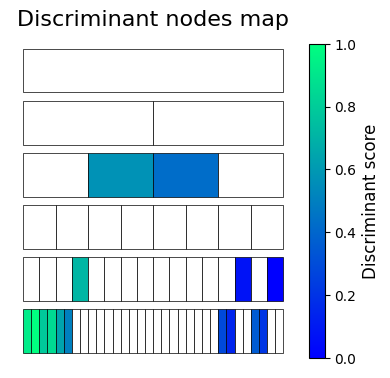

In [33]:
wp = LDB_Decomposition(X, y, discriminant_method='DE') #discriminant_method='KL','FC','DE','RY'
wp.LDB_WP()
print(wp.basis)
print(wp.basis_score)
wp.nodes_maps()
x = wp.LDB_fit(X)
X = np.array(x)

### Clasificador

In [34]:
print('Tamaño X:', X.shape, 'Tamaño y:', y.shape)

Tamaño X: (80, 1009) Tamaño y: (80,)


In [35]:
# Normalización
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

X_data = X  
clf = LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

acc = []
for coeficients in range(1,len(X_data[0])):
    X = X_data[:, :coeficients]
    run_acc = []
    for run in range(10):
        scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
        run_acc.append(np.mean(scores))
    acc.append(np.mean(run_acc))

plt.figure()
plt.plot(acc)
plt.show()

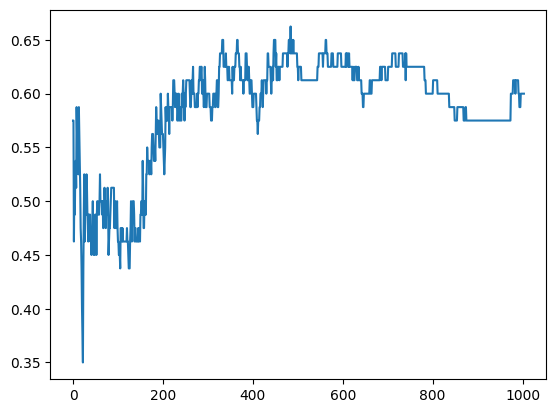

In [ ]:
from sklearn.svm import SVC

X_data = X  
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

acc = []
for coeficients in range(1,len(X_data[0])):
    X = X_data[:, :coeficients]
    run_acc = []
    for run in range(10):
        scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
        run_acc.append(np.mean(scores))
    acc.append(np.mean(run_acc))

plt.figure()
plt.plot(acc)
plt.show()

### Validation

#### Tarea 2

In [ ]:
X_T2 = dictionary[ini+str(volunteer)]['Lower']['Task2']['X']
Y_T2 = dictionary[ini+str(volunteer)]['Lower']['Task2']['Y']

(30, 5, 1000)


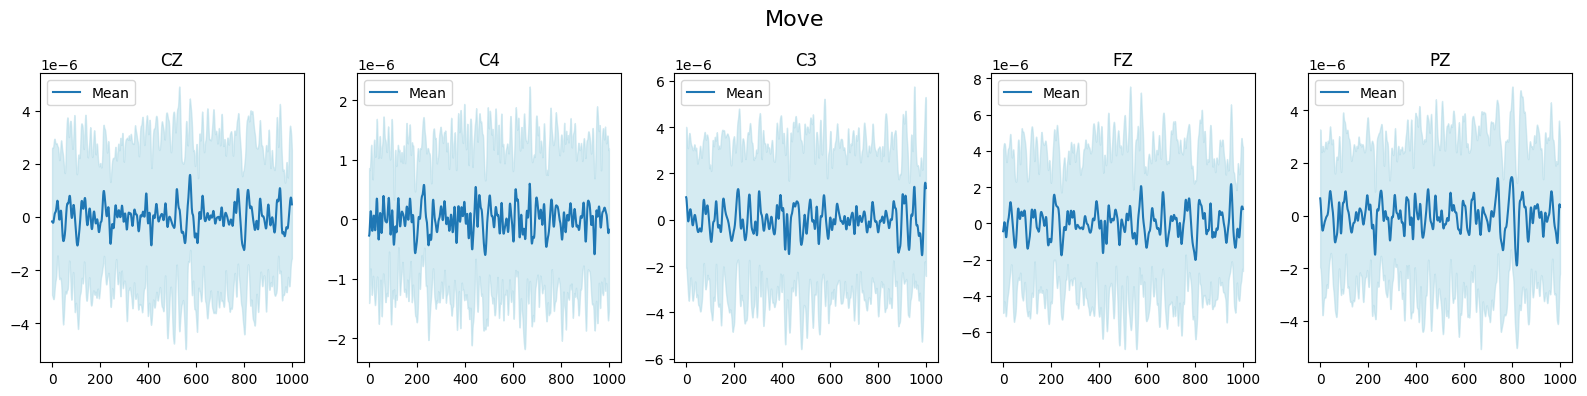

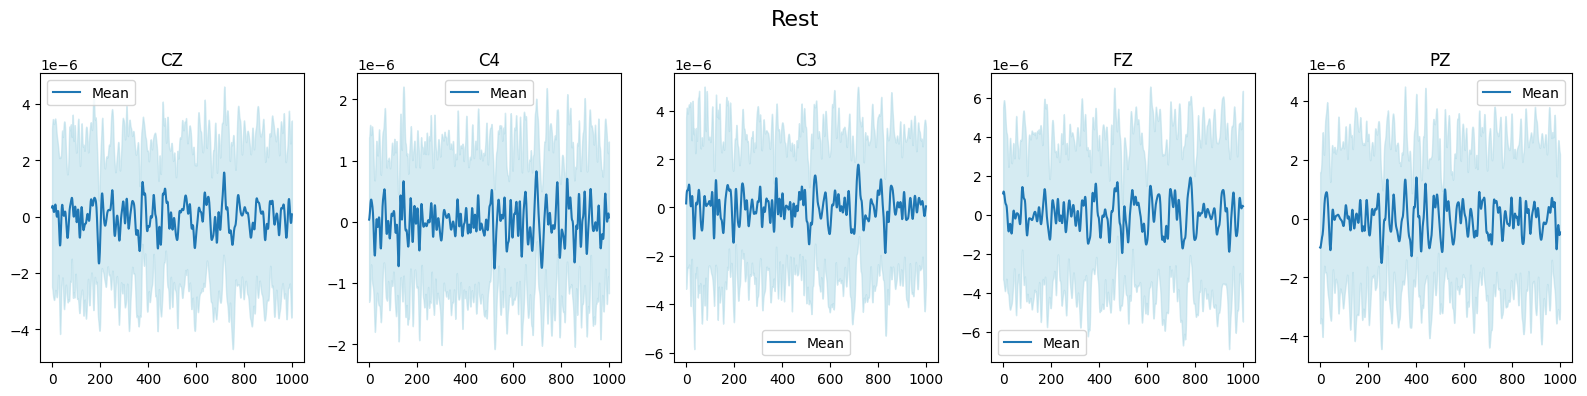

In [ ]:
print((X_T2['Move'].shape))
graph_mean_feet(X_T2['Move'],feet_channels,'Move')
graph_mean_feet(X_T2['Rest'],feet_channels,'Rest')

In [ ]:
laplace_move = laplacian_filter(X_T2['Move'])
trials, samples = laplace_move.shape
print(f"Move Trials={trials}|Samples={samples}")
laplace_rest = laplacian_filter(X_T2['Rest'])
trials, samples = laplace_rest.shape
print(f"Rest Trials={trials}|Samples={samples}")

Move Trials=30|Samples=1000
Rest Trials=30|Samples=1000


In [ ]:
X_test = np.concatenate((laplace_move,laplace_rest), axis=0)
y_test = np.concatenate((np.ones(len(laplace_move)),(np.zeros(len(laplace_rest)))), axis=0)

# WP_LDB fit
x = wp.LDB_fit(X_test)
X_test = np.array(x)

y_pred = lda.predict(X_test)


# Calcular métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy promedio: {acc:.4f}')
print(f'Precision promedio: {prec:.4f}')
print(f'Recall promedio: {rec:.4f}')
print(f'F1-score promedio: {f1:.4f}')


cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
cm_display.plot()
plt.show()

NotFittedError: This LinearDiscriminantAnalysis instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### Tarea 3

In [ ]:
X_T3 = dictionary[ini+str(volunteer)]['Lower']['Task3']['X']
Y_T3 = dictionary[ini+str(volunteer)]['Lower']['Task3']['Y']

(30, 5, 1000)


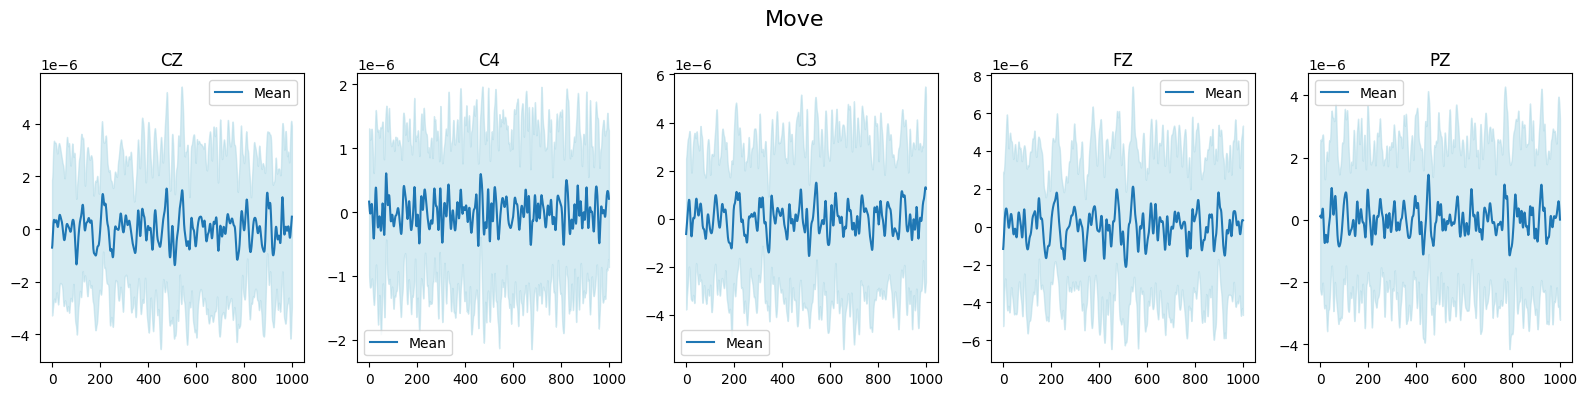

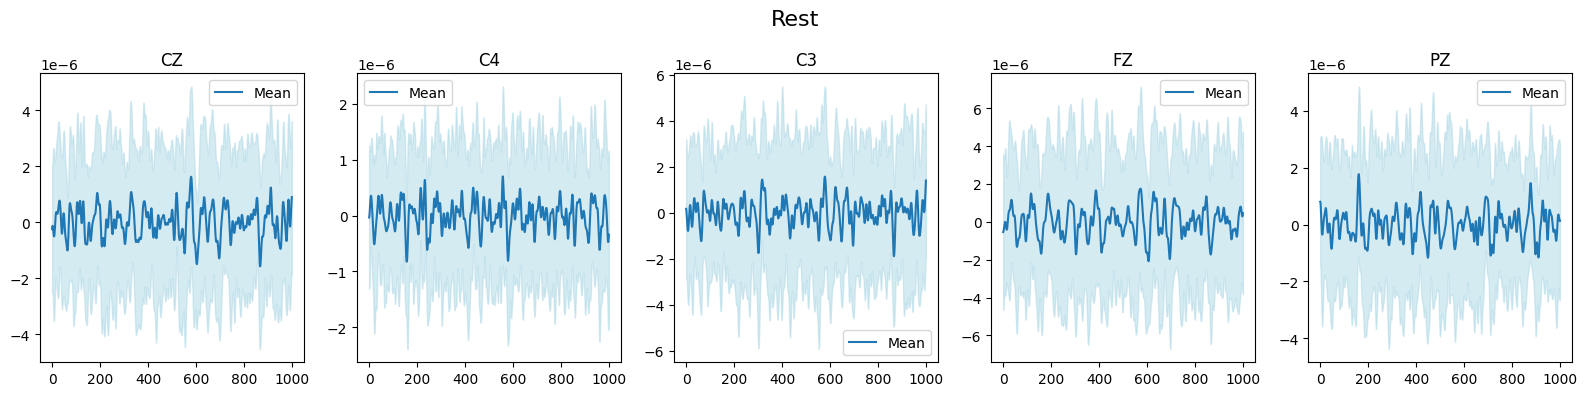

In [ ]:
print((X_T3['Move'].shape))
graph_mean_feet(X_T3['Move'],feet_channels,'Move')
graph_mean_feet(X_T3['Rest'],feet_channels,'Rest')

In [ ]:
laplace_move = laplacian_filter(X_T3['Move'])
trials, samples = laplace_move.shape
print(f"Move Trials={trials}|Samples={samples}")
laplace_rest = laplacian_filter(X_T3['Rest'])
trials, samples = laplace_rest.shape
print(f"Rest Trials={trials}|Samples={samples}")

Move Trials=30|Samples=1000
Rest Trials=30|Samples=1000


Accuracy promedio: 0.5167
Precision promedio: 0.5171
Recall promedio: 0.5167
F1-score promedio: 0.5133


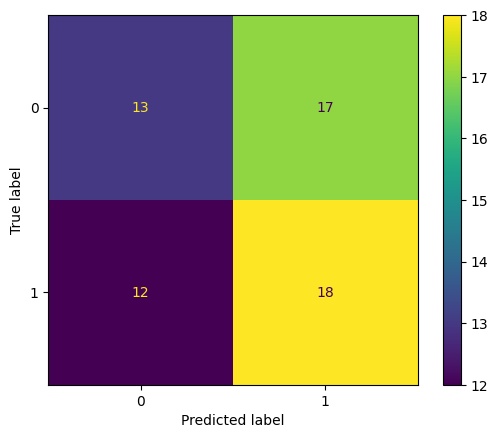

In [ ]:
X_test = np.concatenate((laplace_move,laplace_rest), axis=0)
y_test = np.concatenate((np.ones(len(laplace_move)),(np.zeros(len(laplace_rest)))), axis=0)

# WP_LDB fit
x = wp.LDB_fit(X_test)
X_test = np.array(x)

y_pred = lda.predict(X_test)


# Calcular métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy promedio: {acc:.4f}')
print(f'Precision promedio: {prec:.4f}')
print(f'Recall promedio: {rec:.4f}')
print(f'F1-score promedio: {f1:.4f}')


cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
cm_display.plot()
plt.show()